# Sentiment Analysis - Customer Review

## Context
An online retail business, A, is addressing the decline in customer engagement and conversion rates due to the underperformance of marketing campaigns, which did not yield the expected return on investment.

A more detailed analysis is required to identify areas for improvement in the marketing strategies and understand the customer behaviors. Therefore, the analysis should focus on understanding customer feedback and emotions during their experience with the product and service, which also plays a crucial role in assessing our operational performance.

## Purpose
In this part, we will conduct the sentiment analysis to:
+ Assess customer experience by calculating the sentiment score based on review text.
+ Categorize reviews into primary reasons, such as Product Price, Product Quality, Delivery, and Customer Service.

Since this analysis is a preparation step for an interactive dashboard in Power BI, we will focus only on the two tasks mentioned above without creating charts to highlight patterns.

## Dataset
Data is extracted by connecting with database in SQL server:
+ Database name: PortfolioProject_MarketingAnalytics
+ Table name: customer_reviews

In [ ]:
# Import necessary libraries

from IPython.display import display
import pandas as pd
import pyodbc
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
# connect the SQL server to fetch data
def fetch_SQLdata():
    conn_str = (
        "Driver={SQL Server};"
        "Server=JAYCHOU\SQLEXPRESS;"
        "Database=PortfolioProject_MarketingAnalytics;"  
        "Trusted_Connection=Yes"
    )
    conn = pyodbc.connect(conn_str)
    query = "SELECT ReviewId, CustomerID, ProductID, ReviewDate, Rating, ReviewText FROM customer_reviews"
    df = pd.read_sql(query, conn)
    conn.close()
    return df
df=fetch_SQLdata()
display(df.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lemin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\lemin\AppData\Local\Temp\ipykernel_10524\733004483.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,ReviewId,CustomerID,ProductID,ReviewDate,Rating,ReviewText
0,1,77,18,2023-12-23,3,"Average experience, nothing special."
1,2,80,19,2024-12-25,5,The quality is top-notch.
2,3,50,13,2025-01-26,4,Five stars for the quick delivery.
3,4,78,15,2025-04-21,3,"Good quality, but could be cheaper."
4,5,64,2,2023-07-16,3,"Average experience, nothing special."


In [ ]:
# preliminary examination of dataset
print("Data Type:")
print(df.dtypes)
print("\nRow Numbers, Column Numbers:")
print(df.shape)

Data Type:
ReviewId       int64
CustomerID     int64
ProductID      int64
ReviewDate    object
Rating         int64
ReviewText    object
dtype: object

Row Numbers, Column Numbers:
(1363, 6)


We have quick glance at dataset for the first 5 rows, data types for each column and the shape of dataset: 1363 rows and 6 columns.
## Data Cleaning
In this part, we will perform data cleaning by identifying and handling missing values in the dataset and remove duplicated  if present.

In [ ]:
# column name
for i in df.columns:
    print(i)

ReviewId
CustomerID
ProductID
ReviewDate
Rating
ReviewText


In [ ]:
# Unique values for each column
for i in df.columns:
    print(f"{i}: {df[i].nunique()} unique values")

ReviewId: 1363 unique values
CustomerID: 100 unique values
ProductID: 20 unique values
ReviewDate: 793 unique values
Rating: 5 unique values
ReviewText: 102 unique values


In [ ]:
# Check null values for each column
print("\nNull values count")
print(df.isnull().sum())


Null values count
ReviewId      0
CustomerID    0
ProductID     0
ReviewDate    0
Rating        0
ReviewText    0
dtype: int64


In [ ]:
duplicates = df[df.duplicated(subset=['ReviewId', 'CustomerID', 'ProductID'], keep=False)]
# Display duplicates
print(duplicates)

Empty DataFrame
Columns: [ReviewId, CustomerID, ProductID, ReviewDate, Rating, ReviewText]
Index: []


After checking all features of dataset, there is no missing value and duplicated data so that it is ready for sentiment analysis.
## Sentiment Analysis
We have a look at chart of overal rating. In this analysis, we will use the VADER model to score the review text in the new column 'SentimentScore'.

In the below graph, most of reviews are 4 or 5 score, which can show the positive feedback of products and service

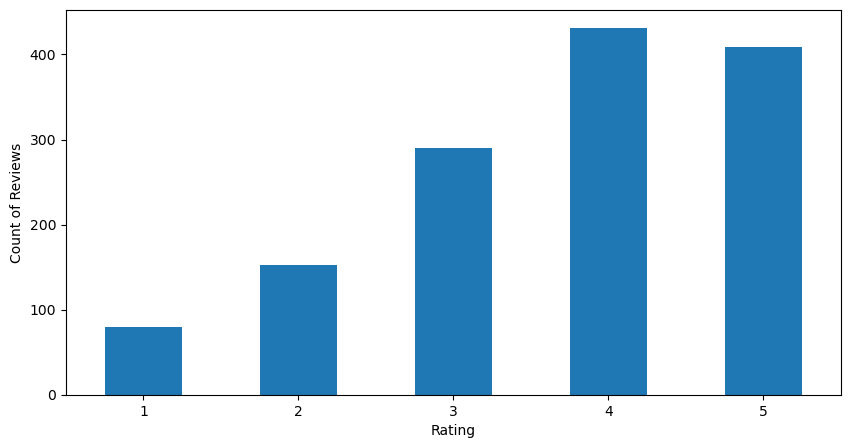

In [ ]:

ax = (
    df['Rating'].value_counts()
    .sort_index()
    .plot(kind='bar', 
          figsize=(10, 5))
)
ax.set_xlabel('Rating')  # Corrected method usage
ax.set_ylabel("Count of Reviews")  # Adding y-axis label for clarity
plt.xticks(rotation=0)  # Keeps x-axis labels readable
plt.show()


In [ ]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# Apply sentiment analysis directly to the 'ReviewText' column
df['SentimentScore'] = df['ReviewText'].apply(lambda review: sia.polarity_scores(review)['compound'])
display(df)

,ReviewId,CustomerID,ProductID,ReviewDate,Rating,ReviewText,SentimentScore
0,1,77,18,2023-12-23,3,"Average experience, nothing special.",-0.3089
1,2,80,19,2024-12-25,5,The quality is top-notch.,0.0000
2,3,50,13,2025-01-26,4,Five stars for the quick delivery.,0.0000
3,4,78,15,2025-04-21,3,"Good quality, but could be cheaper.",0.2382
4,5,64,2,2023-07-16,3,"Average experience, nothing special.",-0.3089
...,...,...,...,...,...,...,...
1358,1359,28,4,2023-05-25,3,Not worth the money.,-0.1695
1359,1360,58,12,2023-11-13,2,"Average experience, nothing special.",-0.3089
1360,1361,96,15,2023-03-07,5,Customer support was very helpful.,0.6997
1361,1362,99,2,2025-12-03,1,Product did not meet my expectations.,0.0000


## Review Category
To continue, we will categorize the review text in main topics: Product Price, Product Quality, Delivery, Customer Service by using the BART model, which is trained on the MNLI (Multi-Genre Natural Language Inference) dataset to predict the likelihood that a given piece of text.

In [ ]:
from transformers import pipeline

# Define the categories you want to classify into
categ = ["Product Price", "Product Quality", "Delivery", "Customer Service"]

# Load the zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Sample text to classify
text = "The customer service was very responsive."

# Perform zero-shot classification
result = classifier(text, candidate_labels=categ)

# Get the label with the highest score (first label)
predicted_category = result['labels'][0]

# Print the predicted category
print(predicted_category)


Customer Service


In [ ]:
def classify(text):
    # Perform zero-shot classification
    result = classifier(text, candidate_labels=categ)
    
    # Get the label with the highest score (first label)
    predicted_category = result['labels'][0]
    
    return predicted_category

# Apply the classify function to the 'ReviewText' column 
df['ReviewCategory'] = df['ReviewText'].apply(classify)

We already inserted a new column to label categories of all reviews and export file to CSV for further analysis in PowerBI. 

In [ ]:
df.to_csv('customer_reviews_updated.csv', index=False)

In [ ]:
display(df.head())

,ReviewId,CustomerID,ProductID,ReviewDate,Rating,ReviewText,SentimentScore,ReviewCategory
0,1,77,18,2023-12-23,3,"Average experience, nothing special.",-0.3089,Customer Service
1,2,80,19,2024-12-25,5,The quality is top-notch.,0.0000,Product Quality
2,3,50,13,2025-01-26,4,Five stars for the quick delivery.,0.0000,Delivery
3,4,78,15,2025-04-21,3,"Good quality, but could be cheaper.",0.2382,Product Price
4,5,64,2,2023-07-16,3,"Average experience, nothing special.",-0.3089,Customer Service


## Conclusion
When analyzing sentiment, combining both the sentiment score and rating provides a more comprehensive understanding of the customer experience. By considering the sentiment expressed in the text along with the numerical rating provided by the customer, we can gain a more nuanced view of their overall satisfaction.
However, there are some limitations when using both pre-trained models in data analysis:

+ Contextual Understanding: VADER relies on a predefined lexicon, which may fail to capture contextual nuances such as sarcasm or irony, leading to misinterpretations.

+ Polarity Misclassification:  In some cases, BART might misinterpret the polarity (positive/negative/neutral) of a sentence if it’s subtle or mixed. 

Despite those limitations, the VADER and BART models still provide valuable insights for short reviews and assist in preparing data to create more insightful dashboards in Power BI.